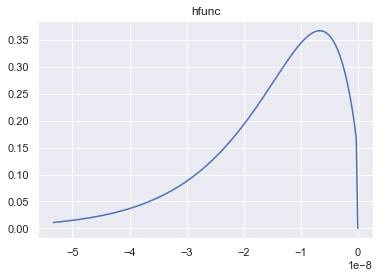

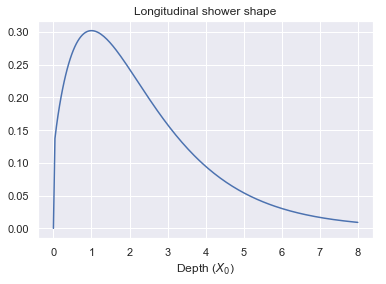

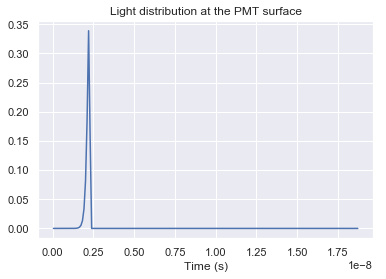

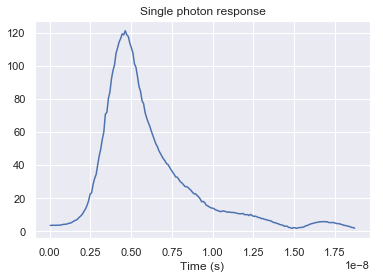

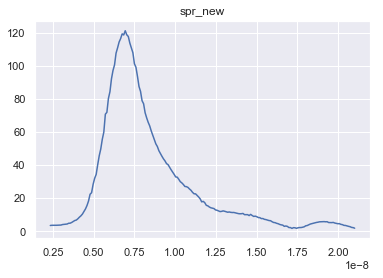

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from shower_utils import *
import convolution_utils
from convolution_utils import Distribution, Convolution

mc_npoints = 100000000

plot_path = 'graphs/pmt_signal/'
nstep = 200
times = numpy.linspace(convolution_utils.times[0], convolution_utils.times[-1], nstep, endpoint=False)
x = np.linspace(0,8,nstep)
y = x*(1/c-1/v)
y = np.flip(y,0)
h = lambda y: shower_func(y/(1/c-1/v))
hlist = list(map(h,y))
plt.plot(y,hlist)
plt.title('hfunc')
plt.show()

fig, ax = plt.subplots()
sho_arr = list(map(shower_func,x))
sho = Distribution(sho_arr, x)
sho.normalize()
ax.plot(sho.x, sho.dist_array)
ax.set_title('Longitudinal shower shape')
ax.set_xlabel('Depth ($X_0$)')
fig.savefig(plot_path+'light_dist.png', dpi=300)
plt.show()
plt.close(fig)

fig, ax = plt.subplots()
ax.plot(times, list(map(shower_func_t, times)))
ax.set_title('Light distribution at the PMT surface')
ax.set_xlabel('Time (s)')
fig.savefig(plot_path+'light_dist_t.png', dpi=300)
plt.show()
plt.close(fig)

r = interp1d(convolution_utils.times, convolution_utils.spr, fill_value='extrapolate')
fig, ax = plt.subplots()
ax.plot(times, r(times))
ax.set_title('Single photon response')
ax.set_xlabel('Time (s)')
fig.savefig(plot_path+'spr_pmt.png', dpi=300)
plt.show()
plt.close(fig)

y1 = times+L/v
w = lambda y: r(y-L/v)
plt.plot(y1, w(y1))
plt.title('spr_new')
plt.show()

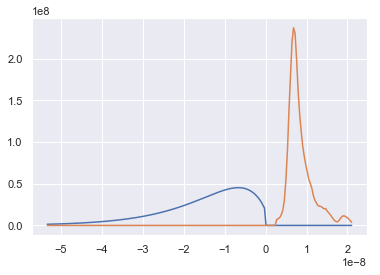

In [10]:
domain = np.linspace(np.amin([y[0],y1[0]]), np.amax([y[-1],y1[-1]]), 200)

light_dist = Distribution(hlist, y)
light_dist.discretize()
light_dist.normalize()
light_dist = light_dist.spline_interpolate(domain, fill_value=0)
spr_dist = Distribution(w(y1), y1)
spr_dist.discretize()
spr_dist.normalize()
spr_dist = spr_dist.spline_interpolate(domain, fill_value=0)

plt.plot(light_dist.x, light_dist.dist_array)
plt.plot(spr_dist.x, spr_dist.dist_array)
plt.show()

In [3]:
result = Convolution(spr_dist, light_dist, mc_npoints)
result.normalize()

100%|██████████| 100000000/100000000 [17:09<00:00, 97174.32it/s]


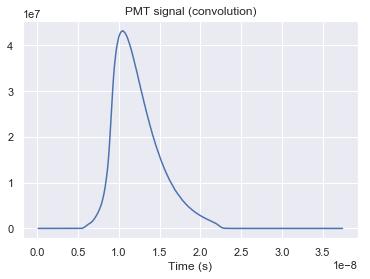

In [21]:
t = np.linspace(2*times[0],2*times[-1],400)
fig = plt.figure()
plt.plot(t, np.flip(result.dist_array, 0))
plt.title('PMT signal (convolution)')
plt.xlabel('Time (s)')
fig.savefig(plot_path+'pmt.png', dpi=300)

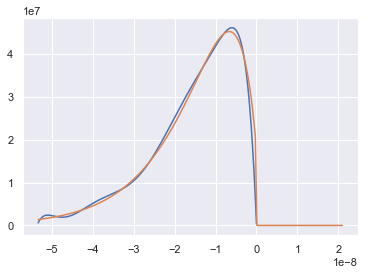

In [22]:
order = 9
spr_cumulants = spr_dist.cumulants(order)
light_cumulants = light_dist.cumulants(order)
result_cumulants = result.cumulants(order)
calc_light_cumulants = [result_cumulants[k]-spr_cumulants[k] for k in range(len(spr_cumulants))]

deconvolution = Distribution.jacobi_recreate_from_cumulants(calc_light_cumulants, y)
deconvolution.normalize()
plt.plot(deconvolution.x, deconvolution.dist_array)
plt.plot(light_dist.x, light_dist.dist_array)

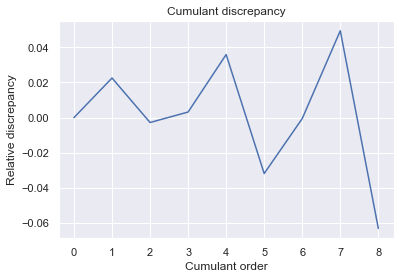

In [23]:
cumulants_discrepancies = [(calc_light_cumulants[k]-light_cumulants[k])/light_cumulants[k]
                           if light_cumulants[k]!=0 else 0 for k in range(len(spr_cumulants))]
fig = plt.figure()
plt.plot(list(range(len(cumulants_discrepancies))), cumulants_discrepancies)
plt.title('Cumulant discrepancy')
plt.xlabel('Cumulant order')
plt.ylabel('Relative discrepancy')
fig.savefig(plot_path+'pmt_discrepancies.png',dpi=300)

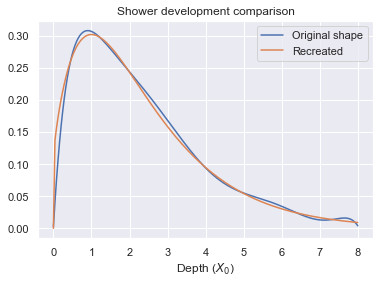

In [24]:
x = np.flip(np.array(deconvolution.x)/(1/c-1/v),0)
h = interp1d(deconvolution.x, deconvolution.dist_array)
g = lambda z: h(z*(1/c-1/v))
glist = list(map(g,x))
shower = Distribution(glist, x)
shower.normalize()

sho_arr = list(map(shower_func,x))
sho = Distribution(sho_arr, x)
sho.normalize()

fig = plt.figure()
plt.plot(shower.x, shower.dist_array)
plt.plot(sho.x, sho.dist_array)
plt.title('Shower development comparison')
plt.xlabel('Depth ($X_0$)')
plt.legend(['Original shape', 'Recreated'])
plt.show()
fig.savefig(plot_path+'light_comparison.png',dpi=300)

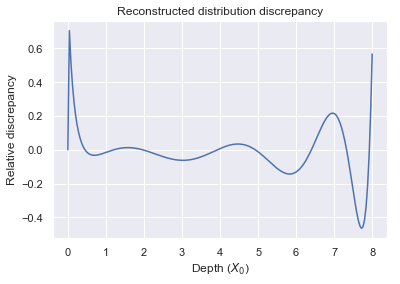

In [25]:
diff = sho - shower
fig = plt.figure()
plt.plot(diff.x, diff.dist_array)
plt.title('Reconstructed distribution discrepancy')
plt.xlabel('Depth ($X_0$)')
plt.ylabel('Relative discrepancy')
fig.savefig(plot_path+'recreated_discrepancies.png',dpi=300)

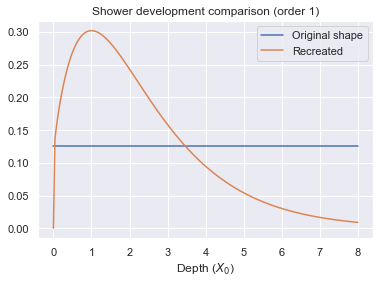

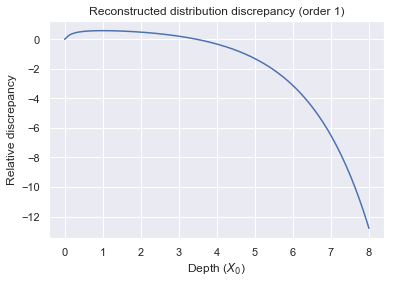

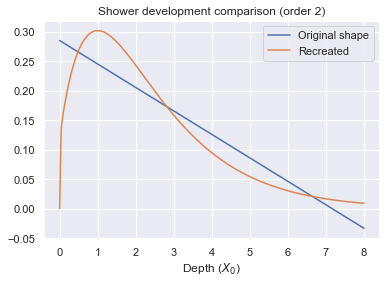

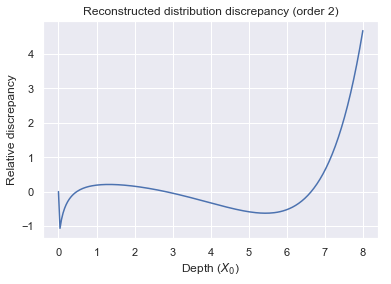

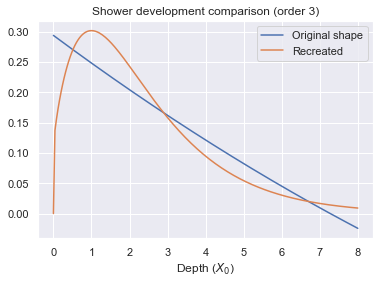

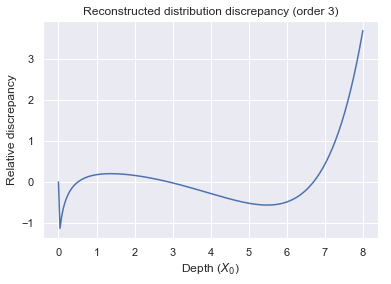

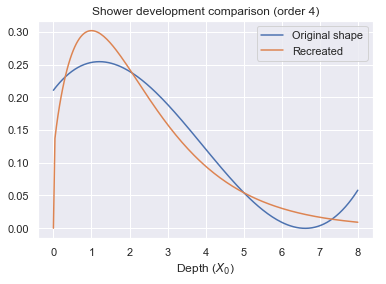

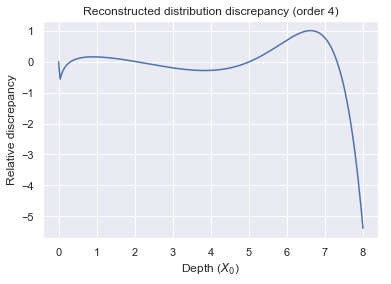

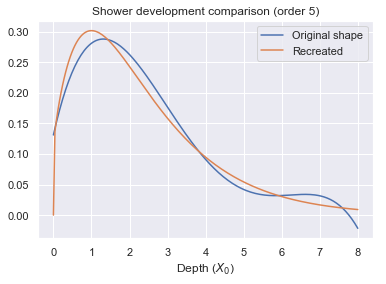

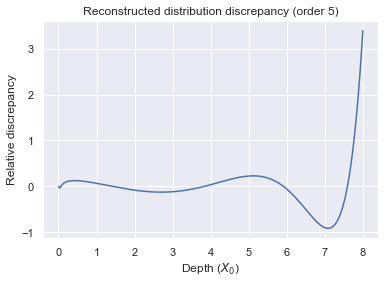

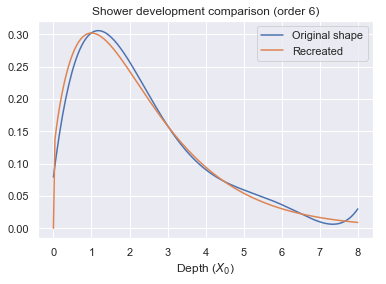

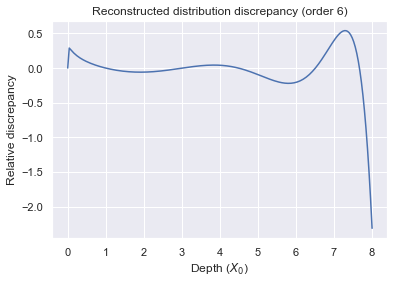

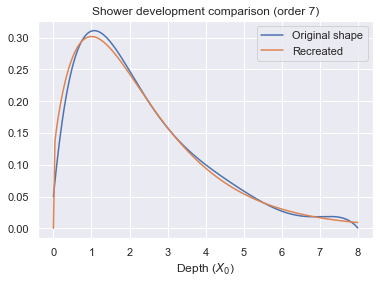

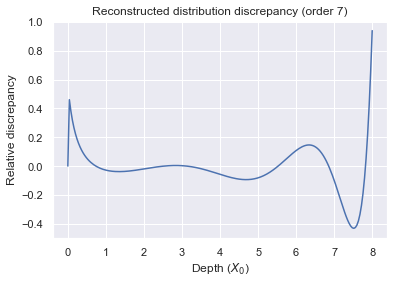

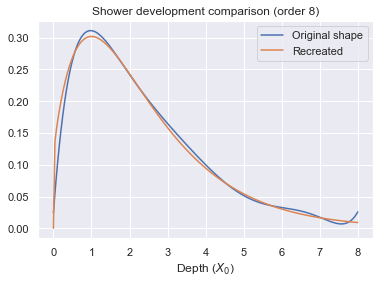

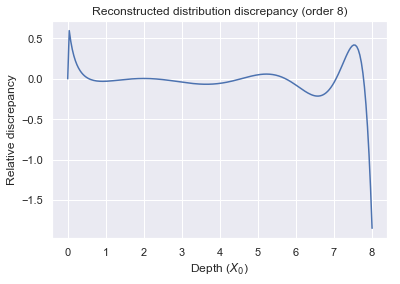

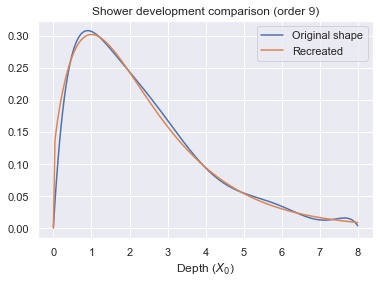

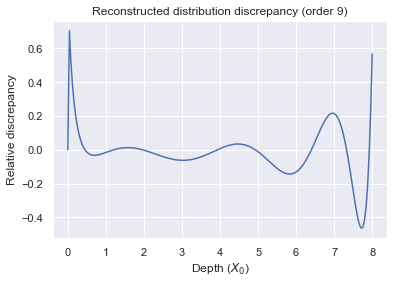

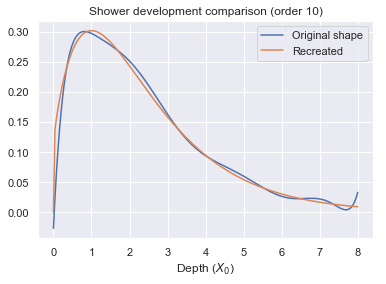

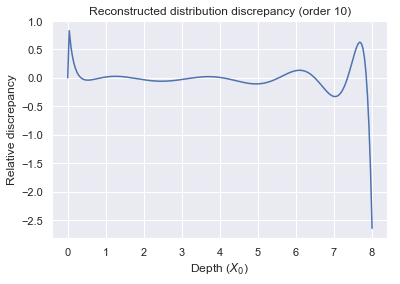

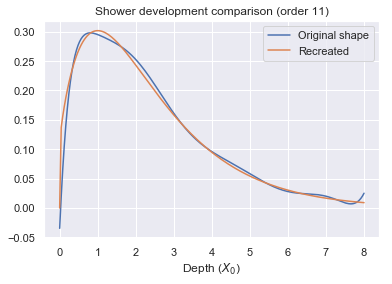

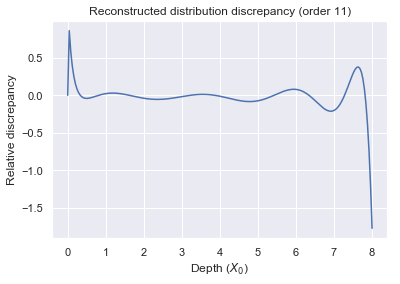

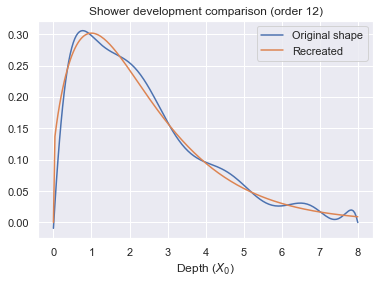

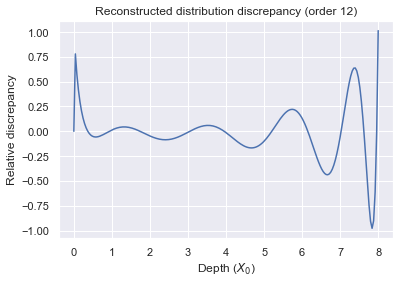

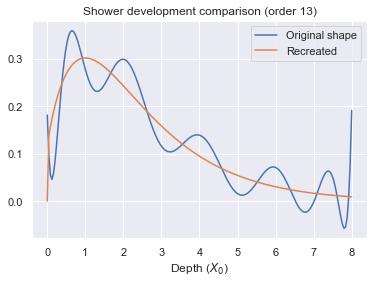

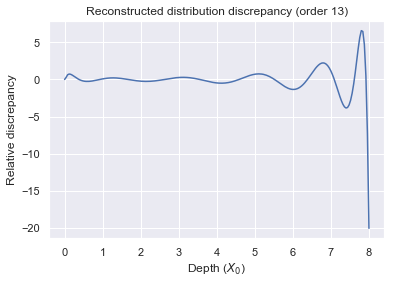

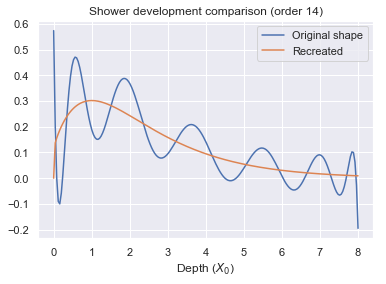

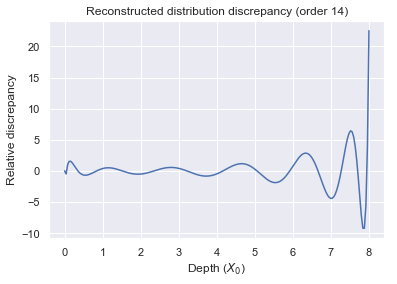

In [30]:
for order in range(1,15):
    spr_cumulants = spr_dist.cumulants(order)
    light_cumulants = light_dist.cumulants(order)
    result_cumulants = result.cumulants(order)
    calc_light_cumulants = [result_cumulants[k]-spr_cumulants[k] for k in range(len(spr_cumulants))]

    deconvolution = Distribution.jacobi_recreate_from_cumulants(calc_light_cumulants, y)
    deconvolution.normalize()

    

    x = np.flip(np.array(deconvolution.x)/(1/c-1/v),0)
    h = interp1d(deconvolution.x, deconvolution.dist_array)
    g = lambda z: h(z*(1/c-1/v))
    glist = list(map(g,x))
    shower = Distribution(glist, x)
    shower.normalize()

    sho_arr = list(map(shower_func,x))
    sho = Distribution(sho_arr, x)
    sho.normalize()

    fig = plt.figure()
    plt.plot(shower.x, shower.dist_array)
    plt.plot(sho.x, sho.dist_array)
    plt.title('Shower development comparison (order '+str(order)+')')
    plt.xlabel('Depth ($X_0$)')
    plt.legend(['Original shape', 'Recreated'])
    plt.show()
    fig.savefig(plot_path+'light_comparison_'+str(order)+'.png',dpi=300)



    diff = sho - shower
    fig = plt.figure()
    plt.plot(diff.x, diff.dist_array)
    plt.title('Reconstructed distribution discrepancy (order '+str(order)+')')
    plt.xlabel('Depth ($X_0$)')
    plt.ylabel('Relative discrepancy')
    fig.savefig(plot_path+'recreated_discrepancies_'+str(order)+'.png',dpi=300)